In [71]:
import numpy as np

import matplotlib.pyplot as plt

In [72]:
# New init + neighbor
def initialize_spin_lattice(im_L, L):
    return np.random.choice([1, -1], size=(im_L, L))

In [73]:
def get_neighbors_2d(y, x, lattice_array):
    im_L,L = lattice_array.shape
    #print(lattice_array)
    #print(np.sum(lattice_array))
    up = ((y - 1) % im_L, x)
    down = ((y + 1) % im_L, x)
    left = (y, (x - 1) % L)
    right = (y, (x + 1) % L)
    return left, right, up, down

In [74]:
def Wolff(lattice_array, h, delta_tau):
    from collections import deque

    im_L, L = lattice_array.shape
    gamma = -0.5 * np.log(np.tanh(delta_tau * h))
    J_x =1 
    J_y = gamma / delta_tau

    # Calculate the probabilities outside the while loop
    ReL_Prob = 1 - np.exp(-2 * J_x * delta_tau)
    ImL_Prob = 1 - np.exp(-2 * np.abs(J_y) * delta_tau)

    # Choose a random site
    x = np.random.randint(0, L)
    y = np.random.randint(0, im_L)
    initial_spin = lattice_array[y, x]

    # Initialize the cluster and the frontier with the initial site
    cluster = {(y, x)}
    frontier = deque([(y, x)])

    while frontier:
        y, x = frontier.popleft()
        neighbors = get_neighbors_2d(y, x, lattice_array)

        for i, neighbor in enumerate(neighbors):
            ny, nx = neighbor
            if lattice_array[ny, nx] == initial_spin and (ny, nx) not in cluster:
                # Use ReL_Prob for left-right neighbors, ImL_Prob for up-down neighbors
                if i< 2 and np.random.rand() < ReL_Prob:
                    cluster.add((ny, nx))
                    frontier.append((ny, nx))
                elif i>= 2 and np.random.rand() < ImL_Prob:
                    cluster.add((ny, nx))
                    frontier.append((ny, nx))

    # Flip the cluster
    for y, x in cluster:
        lattice_array[y, x] *= -1

    return lattice_array

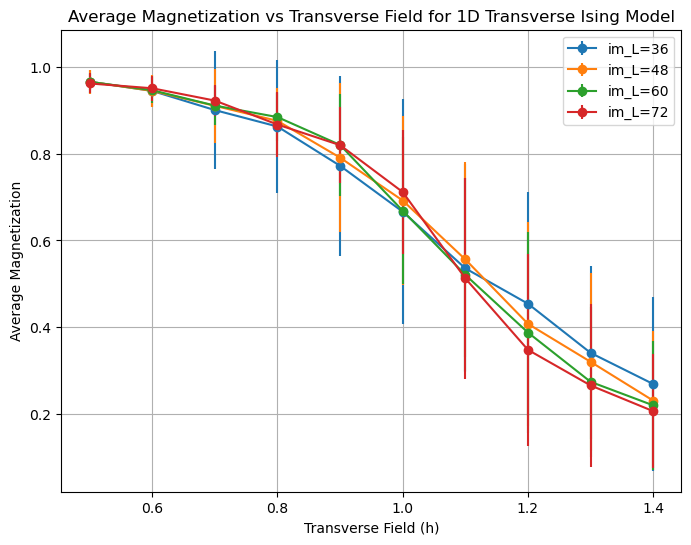

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
im_L_values = [36,48,60,72]  # sizes of the imaginary time direction
L = 16  # size of the lattice
num_steps = 10000
thermalization_steps = 5000
h_field = np.arange(0.5,1.5,0.1)
measurement_interval = 100
delta_tau = 0.1

plt.figure(figsize=(8, 6))

for im_L in im_L_values:
    magnetizations = []
    magnetization_errors = []
    for h in h_field:
        # Initialize the lattice
        lattice = initialize_spin_lattice(im_L, L)

        # Thermalize the system
        for step in range(thermalization_steps):
            lattice = Wolff(lattice, h, delta_tau)

        # Measure the magnetization
        magnetization_measurements = []
        for step in range(num_steps):
            lattice = Wolff(lattice, h, delta_tau)
            if step % measurement_interval == 0:
                magnetization_measurements.append(np.abs(np.sum(lattice)) /(im_L*L))
        average_magnetization = np.mean(magnetization_measurements)
        magnetization_error = np.std(magnetization_measurements)
        magnetizations.append(average_magnetization)
        magnetization_errors.append(magnetization_error)

    plt.errorbar(h_field, magnetizations, yerr=magnetization_errors, fmt='o-', label=f'im_L={im_L}')

plt.xlabel('Transverse Field (h)')
plt.ylabel('Average Magnetization')
plt.title('Average Magnetization vs Transverse Field for 1D Transverse Ising Model')
plt.legend()
plt.grid(True)
plt.show()